<a href="https://colab.research.google.com/github/wliberatoc/PI/blob/main/06_11_PI_Tarefa_7_(Sexta_Semana_(ERE)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruções

1. Resolva todos os exercícios abaixo.
2. Salve uma cópia desse notebook em um repositório no GitHub.
3. Envie o link do repositório criado para o professor.
4. Envie um áudio curto ao professor explicando cada solução criada por você.

#1. Segmentação de Imagens com K-Means

Quando falamos de segmentação de imagens, dizemos que vamos localizar segmentos das imagens. Um algoritmo que realiza essa tarefa é o K-Means.

No vídeo abaixo, eu mostro como usar esse algoritmo para fazer quantização de imagens, ou seja, representar as cores originais em menos quantidades.

Dito isso, assista o vídeo abaixo e implemente um algoritmo que transforma qualquer imagem em um gráfico para jogo 8 num_bits. Assim, pegue uma imagem e gere ela novamente com apenas 256 cores usando o K-means.

<a href="https://www.youtube.com/watch?v=iHlve4t5z-0"><img src="https://img.youtube.com/vi/iHlve4t5z-0/mqdefault.jpg"/></a>

OBS: Se interessar, discuto o algoritmo K-means em mais detalhes nos vídeos abaixo.

<a href="https://www.youtube.com/watch?v=2hsMErlQtcI"><img src="https://img.youtube.com/vi/2hsMErlQtcI/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=p2twwtegYkU"><img src="https://img.youtube.com/vi/p2twwtegYkU/mqdefault.jpg"/></a>

Imagem real:


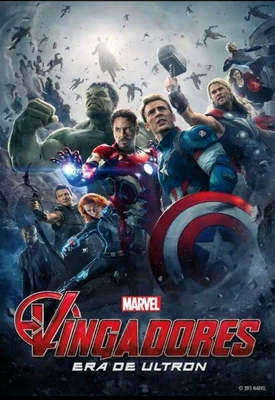

Imagem com 8 bits:


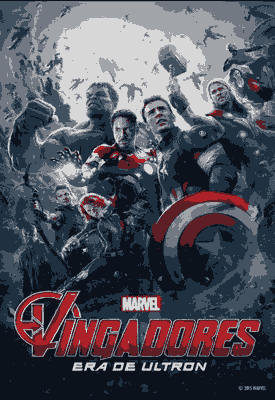

Imagem com 256 bits:


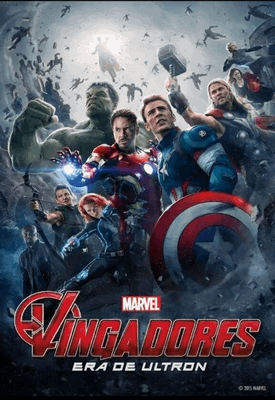

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def quantizar(img,num_bits):
  Z = img.reshape((-1,3))
  Z = np.float32(Z)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40 , 0.1)
  _,labels, centroides = cv2.kmeans(Z, num_bits, None, criteria, 40, cv2.KMEANS_RANDOM_CENTERS)
  centroides = np.uint8(centroides)
  imgemColoridaComCentroides = centroides[labels.flatten()]
  imagemQuantizada = imgemColoridaComCentroides.reshape((img.shape))
  print("Imagem com", num_bits, "bits:")
  cv2_imshow(imagemQuantizada)

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PI/vingadores.jpg')
print("Imagem real:")
cv2_imshow(img)
quantizar(img,8)
quantizar(img,256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

#2. Segmentação usando o algoritmo GrabCut

Quando o assunto é obter o segmento exato que contém um objeto, o algoritmo GrabCut é excelente.

Nos vídeos abaixos, há exemplos de sua implementação. 

<a href="https://www.youtube.com/watch?v=HBp6vQXFQgc"><img src="https://img.youtube.com/vi/HBp6vQXFQgc/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=DyRfAIQfVug"><img src="https://img.youtube.com/vi/DyRfAIQfVug/mqdefault.jpg"/></a>

Baseado nisso e nos conhecimentos anteriores, crie um algoritmo que segmente sua imagem e adicione por cima do fundo com efeito de borramento, usando um dos filtros explicados em lições passadas.

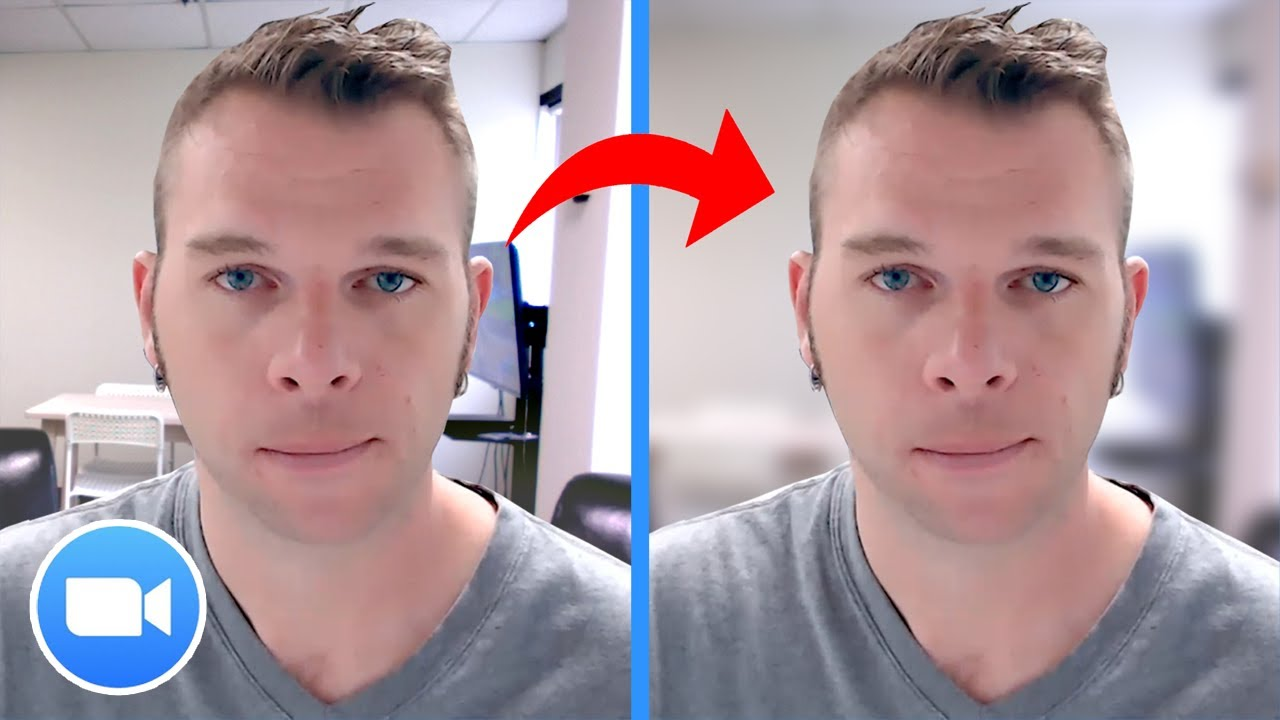

In [ ]:
#não funciona no colab
from tkinter import *
from PIL import Image
from PIL import ImageTk
import tkinter.filedialog as tkFileDialog
import tkinter.messagebox
import cv2
import numpy as np

class GrabCutGUI(Frame):
    def __init__(self, master = None):
        #invoca o construtor da classe pai Frame
        Frame.__init__(self, master)

        #inicializar a interface gráfica
        self.iniciaUI()

    def iniciaUI(self):
        #preparando a janela
        self.master.title("Janela da Imagem Segmentada")
        self.pack()

        #computa ações de mouse
        self.computaAcoesDoMouse()

        #carregando a imagem do disco
        self.imagem = self.carregaImagemASerExibida()

        #criar um canvas que receberá a imagem
        self.canvas = Canvas(self.master, width = self.imagem.width(), height = self.imagem.height(), cursor = "cross")

        #desenhar a imagem que carreguei no canvas
        self.canvas.create_image(0, 0, anchor = NW, image = self.imagem)
        self.canvas.image = self.imagem #pra imagem não ser removida pelo garbage collector

        #posiciona todos os elementos no canvas
        self.canvas.pack()

    def computaAcoesDoMouse(self):
        self.startX = None
        self.startY = None
        self.rect   = None
        self.rectangleReady = None
        
        self.master.bind("<ButtonPress-1>", self.callbackBotaoPressionado)
        self.master.bind("<B1-Motion>", self.callbackBotaoPressionadoEmMovimento)
        self.master.bind("<ButtonRelease-1>", self.callbackBotaoSolto)

    def callbackBotaoSolto(self, event):
        if self.rectangleReady:
            #Inverte o valor inicial e final de X para um retângulo feito da direita para a esquerda
            if(event.x < self.startX):
                aux = event.x
                event.x = self.startX
                self.startX = aux
            #Inverte o valor inicial e final de Y para um retângulo feito de baixo para cima
            if(event.y < self.startY):
                aux = event.y
                event.y = self.startY
                self.startY = aux
                
            #Calcula o tamanho em X
            variacaoX = event.x - self.startX
            #Calcula o tamanho em Y
            variacaoY = event.y - self.startY
            #Se o tamanho X ou Y for menor que 100 nada acontece
            if(variacaoX + variacaoY < 200):
                tkinter.messagebox.showwarning(title="Retangulo Invalido", message="Desenhe um retângulo maior!")
                return

            #Cria uma versão embaçada da imagem
            fundoEmbaçado = cv2.blur(self.imagemOpenCV,(11,11))
            
            #criar uma nova janela
            windowGrabcut = Toplevel(self.master)
            windowGrabcut.wm_title("Segmentation")
            windowGrabcut.minsize(width = self.imagem.width(), height = self.imagem.height())

            #criar canvas pra essa nova janela
            canvasGrabcut = Canvas(windowGrabcut, width = self.imagem.width(), height = self.imagem.height())
            canvasGrabcut.pack()
            #aplicar grabcut na imagem
            mask = np.zeros(self.imagemOpenCV.shape[:2], np.uint8)
            rectGcut = (int(self.startX), int(self.startY), int(variacaoX), int(variacaoY))
            fundoModel = np.zeros((1, 65), np.float64)
            objModel = np.zeros((1, 65), np.float64)

            #invocar grabcut
            cv2.grabCut(self.imagemOpenCV, mask, rectGcut, fundoModel, objModel, 5, cv2.GC_INIT_WITH_RECT)
            xyFace = [-1,-1]
            #preparando imagem final
            maskFinal = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            imgFinal = self.imagemOpenCV * maskFinal[:,:,np.newaxis]
            for x in range(0, self.imagemOpenCV.shape[1]):
                for y in range(0, self.imagemOpenCV.shape[0]):
                    if(maskFinal[y][x] == 0):#Onde a marcara for preta, recebe o frame da imagem embaçada
                        imgFinal[y][x][0] = fundoEmbaçado[y][x][0]
                        imgFinal[y][x][1] = fundoEmbaçado[y][x][1]
                        imgFinal[y][x][2] = fundoEmbaçado[y][x][2]
            #converter de volta do opencv pra Tkinter   
            imgFinal = cv2.cvtColor(imgFinal, cv2.COLOR_BGR2RGB)
            imgFinal = Image.fromarray(imgFinal)
            imgFinal = ImageTk.PhotoImage(imgFinal)

            #inserir a imagem segmentada no canvas
            canvasGrabcut.create_image(0, 0, anchor = NW, image = imgFinal)
            canvasGrabcut.image = imgFinal          

    def callbackBotaoPressionadoEmMovimento(self, event):
        #novas posicoes de x e y
        currentX = self.canvas.canvasx(event.x)
        currentY = self.canvas.canvasy(event.y)

        #atualiza o retângulo a ser desenhado
        self.canvas.coords(self.rect, self.startX, self.startY, currentX, currentY)

        #verifica se existe retângulo desenhado
        self.rectangleReady = True

    def callbackBotaoPressionado(self, event):
        #convertendo o x do frame, pro x do canvas e copiando isso em startX
        self.startX = self.canvas.canvasx(event.x)
        self.startY = self.canvas.canvasy(event.y)

        if not self.rect:
            self.rect = self.canvas.create_rectangle(0, 0, 0, 0, outline="blue")

    def carregaImagemASerExibida(self):
        caminhoDaImagem = tkFileDialog.askopenfilename()

        self.imagemOpenCV = cv2.imread(caminhoDaImagem)

        #converte de opencv para o formato PhotoImage
        image = cv2.cvtColor(self.imagemOpenCV, cv2.COLOR_BGR2RGB)

        #converte de OpenCV pra PIL
        image = Image.fromarray(image)

        #converte de PIL pra PhotoImage
        image = ImageTk.PhotoImage(image)

        return image
            

def main():
    #inicializa a Tkinter
    root = Tk()

    #cria a aplicação
    appcut = GrabCutGUI(master = root)

    #cria o loop do programa
    appcut.mainloop()

if __name__ == "__main__":
    main()


#3. Comece a implementar o trabalho final

Apresente um código com o início do desenvolvimento de seu trabalho final. Explique no áudio o que você fez e como funciona.

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/ImagensPoluição'

imagens,info = carregaImagensPorData(dir)

imagensHSV = []
for imagem in imagens:
  imagensHSV.append(cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV))

h_bins = 50
s_bins = 60
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

listaHistogramas = []
nH = 0
for imagem in imagens:#HSV:
  listaHistogramas.append(cv2.calcHist([imagem], channels, None, histSize, ranges, accumulate=False))
  cv2.normalize(listaHistogramas[nH], listaHistogramas[nH], alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  nH += 1

referencia0 = listaHistogramas[0] #Imagem mais limpa
info[0] += 'antes da tragédia.'
referencia100 = listaHistogramas[1] #Imagem mais poluida
info[1] += 'logo após a tragédia, comparação com a imagem mais "limpa" = ' + str(cv2.compareHist(referencia0, referencia100, 1)) + '.'

for i in range(2,nH):
  info[i] += 'comparação com a imagem mais "limpa" = ' + str(cv2.compareHist(referencia0, listaHistogramas[i], 1)) + ', '
  info[i] += 'comparação com a imagem mais "suja" = ' + str(cv2.compareHist(referencia100, listaHistogramas[i], 1)) + '.'